# Đồ án cuối kỳ - Phân tích chủ đề văn bản
(Cập nhật 07/01/2021)

Nhóm: 12

Thành viên nhóm:
- Vũ Đăng Hoàng Long - MSSV: 18120203
- Nguyễn Huỳnh Đại Lợi - MSSV: 18120198

---
# Giới thiệu đồ án

Chủ đề: Nhận diện chủ đề của một đoạn văn bản bất kỳ.

Input: một đoạn văn bản bất kỳ.

Output: một trong 18 phân lớp sau:

| | | |
| :- | :- | :- |
| 1. thời sự quốc tế | 2. thời sự trong nước | 3. du lịch |
| 4. kinh doanh | 5. giải trí | 6. công nghệ |
| 7. nhà đất | 8. sức khỏe | 9. giáo dục |
| 10. khoa học | 11. thể thao | 12. văn hóa |
| 13. pháp luật | 14. yêu | 15. xe |
| 16. thời trang | 17. nhịp sống trẻ | 18. ăn gì |

Nguồn dữ liệu: tất cả bài báo thu thập từ trang báo điện tử Tuổi trẻ Online (https://tuoitre.vn/).

Mục đích:
- Khách quan: phục vụ việc nhận diện chủ đề một cách tự động.
- Chủ quan: lọc các bài viết trên mạng xã hội theo chủ đề mà em quan tâm để tránh lãng phí thời gian lướt facebook chỉ để tìm chủ đề mà em quan tâm 🥴.

---
# Phần đồ án

## Cài đặt thư viện

(có thể bỏ qua cell ở đây nếu cài rồi)

In [1]:
%%capture
# Cài đặt thư viện cần thiết
!pip3 install pandas;
!pip3 install tqdm;
!pip3 install bs4;
!pip3 install regex;
!pip3 install numpy;
!pip3 install pyvi;
!pip3 install gensim;
!pip3 install matplotlib;
!pip3 install seaborn;
!pip3 install -U scikit-learn;

## Import thư viện

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import regex as re
import time # Dùng để sleep chương trình
from tqdm.notebook import tqdm # Hiện thanh progress cho đẹp :D
tqdm.pandas()

# Thư viện để request và parse HTML
import requests
from bs4 import BeautifulSoup

# Các thư viện liên quan tới ngôn ngữ và NLP
from pyvi import ViTokenizer # Thư viện NLP tiếng Việt
import gensim
import unicodedata # Thư viện unicode

# Thư viện liên quan của Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Tạo pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector

# Các mô hình học
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier # Phương pháp bagging

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


---
## 1. Thu thập dữ liệu

In [3]:
# Thiết lập đường dẫn cho phần 1
dir_1 = "src/scraped_data/"

Dữ liệu trong đồ án này được thu thập toàn bộ từ trang báo mạng Tuổi Trẻ Online (https://tuoitre.vn/).

Khi mới vào trang chủ, có thể thấy trang báo này phân bổ thứ tự và cấu trúc thông tin không đều, rất khó để có thể thu thập được. Tuy nhiên, may mắn là trang báo này có mục tin mới nhất chứa toàn bộ tin từ các chuyên mục và có tổ chức các mục có cấu trúc rõ ràng (Hình 1).

![Hình 1](resources/tin-moi-nhat.png "Hình 1")

Khi người dùng kéo xuống cuối trang, sẽ có nút "Xem thêm" (Hình 2). Người dùng nhấn vào đây và tin tức cũ hơn sẽ hiện ngay bên dưới để người dùng kéo xuống tiếp.

![Hình 2](resources/xem-them.png "Hình 2")

Thoáng nhìn qua, quy trình lướt tin tức sẽ bao gồm: Vào mục tin mới -> Kéo xuống cuối trang -> Bấm "Xem thêm" -> Kéo xuống cuối trang và lặp lại. Như vậy với cách làm đơn giản nhất là mô phỏng click chuột của người dùng để bấm nút xem thêm càng nhiều càng tốt, sau đó lấy file HTML của trang về và thực hiện parse (Đây chính là cách làm trong phiên bản đầu của quy trình này của nhóm). Tuy nhiên cách này rất thiếu hiệu quả bởi lẽ máy sẽ cần phải mở trình duyệt lên và mô phỏng thao tác của người dùng -> rất chậm do thời gian tải trang và tốn tài nguyên xử lý của máy tính do phải render trang web. Trong phiên bản đầu nhóm đã mất khoảng vài phút để có thể lấy được 480 tin.

Nhận thấy rằng trang tin này có một đặc điểm là có thể lăn chuột vô tận, nhóm tìm hiểu và phát hiện rằng có thể cải thiện hiệu suất của quy trình này lên rất nhiều lần! Cụ thể, khi người dùng bấm vào nút "Xem thêm", trang web sẽ gửi yêu cầu lên server và nhận về một file HTML có cấu trúc đơn giản chứa thông tin các bài báo (Hình 3). Sau đó trình duyệt sẽ thực hiện thay đổi DOM của trang web để thêm các tin này vào bên dưới, tạo hiệu ứng lăn chuột vô tận. Do vậy, thay vì phải đợi trình duyệt render trang web, nhóm có thể request thẳng đường link giống cách trang web request lên server. Việc làm này sẽ rút ngắn rất nhiều thời gian của quá trình thu thập dữ liệu!

![Hình 3](resources/xem-them-network.png "Hình 3")

Khi sử dụng công cụ theo dõi network của trình duyệt, nhóm phát hiện ra rằng đường link request tin mới của trang web khi bấm nút xem thêm lần đầu là "https://tuoitre.vn/timeline/0/trang-1.htm". Rất có thể khi thay thế trang-1 thành trang-2, trang-3,... chúng ta sẽ thu được các kết quả là tin mới của các lần bấm thứ 2, thứ 3,... vào nút "Xem thêm" (điều này đúng, nhóm đã kiểm chứng).

Đoạn code bên dưới sẽ thực hiện request vào đường link trên và thực hiện parse với BeautifulSoup như HTML bình thường để lấy đường link và chuyên mục của các tin tức. Sau đó sẽ thực hiện request trang tin chính từ đường link thu thập được và lấy các thông tin tiêu đề, mô tả và nội dung.

Kết quả sẽ được in bằng hàm tail() giúp có thể nắm được số lượng data lấy được thông qua index.

In [4]:
# Thử nghiệm url đầu tiên
url = "https://tuoitre.vn/timeline/0/trang-1.htm"

# Lấy danh sách news_items
html_text = requests.get(url).text
html_tree = BeautifulSoup(html_text, 'html.parser')
news_items = html_tree.findAll('li', class_='news-item')

# Lấy ra link, title và category từ news_items
raw_data = pd.DataFrame(columns=["links","title","description","content","class"])
for item in news_items:
    title = item.find('h3', class_='title-news').text.replace('\n','')
    link = "https://tuoitre.vn" + item.find('a').attrs["href"]
    category = item.find('a', class_='category-name').text
    raw_data = raw_data.append({"links":link, "title":title, "class":category}, ignore_index=True)

raw_data.tail()

,links,title,description,content,class
15,https://tuoitre.vn/nghe-nhan-minh-xa-chuyen-hu...,Nghệ nhân Minh Xa chuyển hướng trồng phong...,NaN,NaN,Cần biết
16,https://tuoitre.vn/gia-thit-heo-co-tang-nhung-...,Giá thịt heo có tăng nhưng không đột biến như ...,NaN,NaN,Kinh doanh
17,https://tuoitre.vn/tp-hcm-du-kien-chi-gan-13-t...,TP.HCM dự kiến chi gần 13 tỉ vớt rác trên sông...,NaN,NaN,Thời sự
18,https://tuoitre.vn/trung-quoc-tim-cach-that-ch...,Trung Quốc tìm cách thắt chặt quan hệ với Phil...,NaN,NaN,Thế giới
19,https://tuoitre.vn/de-phong-thuyen-vien-nho-vo...,Đề phòng thuyền viên nhớ vợ... trốn khai báo y...,NaN,NaN,Sức khỏe


In [5]:
%%time
for _, row in raw_data.iterrows():
    news_page = requests.get(row["links"]).content
    news_tree = BeautifulSoup(news_page, "html.parser")
    # Lấy mô tả
    try:
        row["description"] = news_tree.find("h2", class_="sapo").text
    except:
        row["description"] = ''
    # Lấy nội dung
    try:
        body = news_tree.find("div", id="main-detail-body")
        content = body.findChildren("p", recursive=False)
        row["content"] = ""
        for x in content:
            row["content"] += x.text
    except:
        row["content"] = ''
    time.sleep(0.05)
    
raw_data.tail()

Wall time: 4.01 s


,links,title,description,content,class
15,https://tuoitre.vn/nghe-nhan-minh-xa-chuyen-hu...,Nghệ nhân Minh Xa chuyển hướng trồng phong...,"Tốt nghiệp đại học xây dựng, đang có côn...",Nghệ nhân Minh Xa (tên thật là Nguyễn Xuân...,Cần biết
16,https://tuoitre.vn/gia-thit-heo-co-tang-nhung-...,Giá thịt heo có tăng nhưng không đột biến như ...,TTO - Nhu cầu thịt heo tăng cao để phục vụ chế...,Tại cuộc họp báo cung cấp thông tin nguồn cung...,Kinh doanh
17,https://tuoitre.vn/tp-hcm-du-kien-chi-gan-13-t...,TP.HCM dự kiến chi gần 13 tỉ vớt rác trên sông...,"TTO - Sau thời gian thí điểm, Sở GTVT TP.HCM c...","Cụ thể, việc vớt rác được thực hiện bằng 1 tàu...",Thời sự
18,https://tuoitre.vn/trung-quoc-tim-cach-that-ch...,Trung Quốc tìm cách thắt chặt quan hệ với Phil...,TTO - Bộ trưởng Ngoại giao Trung Quốc Vương Ng...,"Theo Đài CGTN, ông Vương sẽ thảo luận với ngườ...",Thế giới
19,https://tuoitre.vn/de-phong-thuyen-vien-nho-vo...,Đề phòng thuyền viên nhớ vợ... trốn khai báo y...,TTO - Đó là cảnh báo của đoàn công tác của Ban...,"Chiều tối 14-1, đoàn công tác của Ban Chỉ đạo ...",Sức khỏe


### Vấn đề phát sinh trong quá trình thu thập dữ liệu tự động hàng loạt

#### Thiếu dữ liệu làm đứt quãng quá trình thu thập
Do khối lượng dữ liệu có thể thu thập được rất lớn (ước tính lên đến hơn 500.000 tin), việc giám sát quá trình khai thác liên tục là không thể. Việc xuất hiện lỗi này đã khiến quá trình khai thác bị ngắt quãng mỗi khi xuất hiện. Nhóm đã khắc phục bằng cách đặt các khối lệnh ```try``` ```catch``` ở mỗi đoạn code parse các phần thông tin, tự động trả về rỗng nếu có lỗi.

#### Lỗi TooManyRedirects: Exceeded 30 redirects
Đây là lỗi xuất hiện khi một trang web tự điều hướng quá 30 lần (con số mặc định có thể chỉnh được).

Với một số server, khi được request sẽ tùy vào thông tin header của request (như trình duyệt, cache,...), server sẽ đính kèm lệnh chuyển hướng vào response và trình duyệt sẽ dùng thông tin đó điều hướng chuyển qua trang web nhất định. Chẳng hạn, khi người dùng điện thoại truy cập vào trang facebook.com, trình duyệt sẽ tự động điều hướng chuyển người dùng tới trang m.facebook.com là trang có giao diện dành cho điện thoại. Request HTTP trong python cũng không phải ngoại lệ khi có thiết lập mặc định là sẽ tự động chuyển hướng cho đến khi không còn nhận được lệnh từ server.

Khi tra cứu lỗi này trên google, nhóm nhận được các đề xuất giải quyết sau:
- Thêm tham số ```allow_redirects=True``` vào lệnh ```requests.get```
- Thêm tham số ```headers``` vào lệnh ```requests.get```. Tham số này chứa các thông tin mặc định của header mà trình duyệt gửi tới server.
- Tạo một ```session``` và thay đổi thuộc tính ```max_redirect``` lên hớn 30.

Với cách 1 vô nghĩa do tham số đó là mặc định sẵn, cách 3 thì không đảm bảo thay đổi bao nhiêu là đủ. Còn với cách 2, lệnh request cung cấp thêm thông tin cho server nhằm tránh tình trạng server không xác định được người dùng và rơi vào vòng lặp redirect vô tận. Tuy nhiên nhóm áp dụng và vẫn không khắc phục được. Khi thử lấy link này thì hoàn toàn không vô được.

Một điều thú vị là khi debug, nhóm phát hiện rằng các link sinh ra lỗi này đều có nội dung về giáo dục (Hình 4). Khi thử tìm kiếm trang riêng có đường link https://tuyensinh.tuoitre.vn/ thì được điều hướng trở về trang https://tuoitre.vn/giao-duc/tuyen-sinh.htm. Kết luận của nhóm: rất có thể trang báo này đã có quá trình thay đổi công nghệ ở một thời điểm nhất định trong quá khứ khiến cho các trang này không truy cập được -> không chỉ trang tin giáo dục mà còn có thể nhiều trang tin khác cũng bị tương tự.

![Hình 4](resources/tuyen-sinh-errors.png "Hình 4")

Quyết định của nhóm là sẽ áp dụng cách khắc phục 2 vì nó hợp lý và áp khối ```try``` ```catch``` điền thông tin trống với các link tiếp tục bị lỗi.

#### Lỗi 502 của trang web được request về
Lỗi này đến từ phía server của trang báo và xuất hiện rất ngẫu nhiên không xác định được. Nhóm đã giải quyết bằng cách đặt vòng lặp ```while``` tại các câu lệnh ```get``` và chỉ ngừng khi quá số lần cho phép hoặc nhận phản hồi 200 tức OK. Tuy nhiên cần chú ý cho phép cả phản hồi 301 vì đây là lệnh điều hướng trang có liên quan tới lỗi ở phần trước có đề cập.

### Thiết lập đoạn code thu thập dữ liệu tự động hàng loạt

(Đoạn code dưới đây dùng cho tác vụ thu thập hàng loạt mà nhóm đã thực hiện chạy trên notebook khác)

In [6]:
def single_request_scraping(index = 1, limit_retry = 100, sleep_time = 0.05):
    '''
    Thu thập các trang tin trong mục tin mới nhất của báo Tuổi Trẻ.
    Mỗi lần thu thập 20 tin. Sử dụng số index để thu thập các trang liên tiếp.
    Với index = 1 tức lấy 20 trang tin mới nhất.

    Lưu ý:
        Khi lấy liên tục cần chọn thời điểm
        vì có khả năng báo cập nhật tin tức mới sẽ làm 
        tin ở trang trước bị đẩy xuống trang sau.

    Param:
        index: số chỉ trang cần request.
    '''
    allow_status = [200, 301]
    s = requests.Session()
    s.headers['User-Agent'] = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1847.131 Safari/537.36'
    url = f"https://tuoitre.vn/timeline/0/trang-{index}.htm"

    # Lấy danh sách news_items
    try:
        response = s.get(url)
        try_left = limit_retry
        while (response.status_code not in allow_status and try_left > 0):
            print(f"Loi {response.status_code} tai trang {index}")
            response = s.get(url)
            try_left -= 1
        html_text = response.text
    except:
        print(f"Loi request tai trang {index}")
        return None
    
    html_tree = BeautifulSoup(html_text, 'html.parser')
    news_items = html_tree.findAll('li', class_='news-item')
    
    # Kiểm tra lỗi nếu không lấy được bất cứ item nào
    if (len(news_items) == 0):
        print(f'Trang {index} khong lay duoc item.')
        print(html_text)
        return None
    elif (len(news_items) != 20):
        print(f"Warning: Trang {index} chi lay duoc {len(news_items)} items.")
    
    # Lấy ra link, title và category từ news_items
    raw_data = pd.DataFrame(columns=["links","title","description","content","class"])
    for item in news_items:
        try:
            title = item.find('h3', class_='title-news').text.replace('\n','')
        except:
            title = ""
        link = "https://tuoitre.vn" + item.find('a').attrs["href"]
        try:
            category = item.find('a', class_='category-name').text
        except:
            category = ""
        raw_data = raw_data.append({"links":link, "title":title, "class":category}, ignore_index=True)
    
    # Tiến hành lấy nội dung từng link
    for _, row in raw_data.iterrows():
        try:
            response = s.get(row["links"])
            try_left = limit_retry
            while (response.status_code not in allow_status and try_left > 0):
                print(f"Loi {response.status_code} tai link {row['links']}")
                response = s.get(row["links"])
                try_left -= 1
            news_page = response.content
        except:
            print(f"Loi request tai link {row['links']}")
            row["description"] = ""
            row["content"] = ""
            continue
            
        news_tree = BeautifulSoup(news_page, "html.parser")
        # Lấy mô tả
        try:
            row["description"] = news_tree.find("h2", class_="sapo").text
        except:
            row["description"] = ''
        # Lấy nội dung
        try:
            body = news_tree.find("div", id="main-detail-body")
            content = body.findChildren("p", recursive=False)
            row["content"] = ""
            for x in content:
                row["content"] += x.text
        except:
            row["content"] = ''
        time.sleep(sleep_time)
    
    return raw_data

In [7]:
#Batch scraping
def batch_scraping(num = 200, output_dir = ""):
    '''
    Thực hiện thu thập toàn bộ dữ liệu trên trang tuoitre.vn
    
    Param:
        num: số lượng trang request cho 1 batch (1 trang = 20 bài báo). Mặc định 4000 bài báo.
    '''
    iter_num = 0  # Số batch bắt đầu
    continue_flag = True # Cờ hiệu kết thúc vòng lặp khi xảy ra lỗi

    while (continue_flag):
        
        '''
        Khởi tạo dataframe rỗng. 
        Sau đó lấy đủ 1 số trang cho 1 batch.
        Rồi export file csv.
        '''
        batch_df = pd.DataFrame(columns=["links","title","description","content","class"])
        for index in range(iter_num*num+1,(iter_num+1)*num+1):
            data = single_request_scraping(index)
            if (data is None):
                continue_flag = False
                break
            print(f"Page {index} complete!")
            batch_df = batch_df.append(data)
        batch_df.to_csv(output_dir + f'crawling_{iter_num}.csv',index=False,encoding="utf-8")    
        iter_num+=1

In [8]:
#batch_scraping(output_dir = dir_1)

---
## 2. Khám phá dữ liệu

In [9]:
# Thiết lập đường dẫn thư mục để dùng trong phần 2
dir_2 = "src/raw_scraped_data_demo/"

Trong phần này nhóm sẽ khám phá các đặc tính của dữ liệu đã thu thập được ở bên trên. Do khối lượng dữ liệu lớn, nhóm chỉ đọc 12 batchs dữ liệu đầu tiên để khám phá và đưa ra hướng cho tiền xử lý. Một số thông tin thống kê cần chạy trên toàn bộ dữ liệu sẽ được thực hiện riêng và cho kết quả ra một file riêng biệt.

### Đọc 12 file đầu

In [10]:
# Import thử 12 file đầu tiên
df = []
for i in tqdm(range(12)):
    df.append(pd.read_csv(dir_2 + f'crawling_{i}.csv'))
    
data_df=pd.concat(df)
data_df.reset_index(drop=True, inplace=True)
data_df.head()

,links,title,description,content,class
0,https://tuoitre.vn/tong-thong-trump-xac-nhan-k...,Tổng thống Trump xác nhận không dự lễ nhậm chứ...,TTO - Tổng thống Mỹ Donald Trump đăng tweet ch...,Sau khi đưa ra cam kết sẽ đảm bảo chuyển giao ...,Thế giới
1,https://tuoitre.vn/dat-nuoc-dat-niem-tin-vao-n...,Đất nước đặt niềm tin vào những học sinh xuất sắc,"TT0 - Tối 8-1, Thủ tướng Chính phủ Nguyễn Xuân...","Chia sẻ tại buổi lễ, Thủ tướng Nguyễn Xuân Phú...",Giáo dục
2,https://tuoitre.vn/luat-su-my-phan-bien-ong-tr...,Luật sư Mỹ phản biện: Ông Trump đâu có kêu ngư...,TTO - Trên chương trình Bill Hemmer Reports củ...,"Ngày 6-1, tình trạng bạo lực đã xảy ra tại tòa...",Thế giới
3,https://tuoitre.vn/thanh-pho-phu-quoc-se-phat-...,Thành phố Phú Quốc sẽ phát triển dựa trên 4 tr...,"TTO - Tối 8-1 tại phường An Thới, chính quyền ...",Phát biểu tại buổi lễ công bố thành lập TP Phú...,Thời sự
4,https://tuoitre.vn/ong-trump-nguoi-ung-ho-toi-...,Ông Trump: Người ủng hộ tôi 'sẽ có tiếng nói t...,TTO - Trong nội dung đăng trên Twitter sau gần...,"""75 triệu người Mỹ yêu nước vĩ đại đã bầu cho ...",Thế giới


### Kích thước và kiểu dữ liệu của các cột

Theo ước tính trong bước thu thập, file đầu tiên ("crawling_0.csv") sẽ có 8000 dòng còn các file còn lại sẽ có 4000 dòng.<br>Tổng cộng tất cả là 8000 ✕ 1 + 4000 ✕ 11 = 52000. Về kiểu dữ liệu thì các cột sẽ có kiểu string.

In [11]:
data_df.shape

(52000, 5)

In [12]:
# Các cột hiện có kiểu dữ liệu gì?
data_df.dtypes

links          object
title          object
description    object
content        object
class          object
dtype: object

### Kiểm tra dữ liệu trùng

In [13]:
data_df[data_df.duplicated(keep=False)].sort_values(by=['links'])

,links,title,description,content,class
48880,/dang-sai-lech-vu-dong-tam-facebooker-chuong-m...,"Đăng sai lệch vụ Đồng Tâm, Facebooker ‘Chương ...","TTO - Ngày 20-1, Cơ quan cảnh sát điều tra Côn...","Facebooker ""Chương May Mắn"" tên thật là Chung ...",Pháp luật
48879,/dang-sai-lech-vu-dong-tam-facebooker-chuong-m...,"Đăng sai lệch vụ Đồng Tâm, Facebooker ‘Chương ...","TTO - Ngày 20-1, Cơ quan cảnh sát điều tra Côn...","Facebooker ""Chương May Mắn"" tên thật là Chung ...",Pháp luật
307,https://tuoitre.vn/1-ca-covid-19-moi-phat-hien...,"1 ca COVID-19 mới, phát hiện sau 3 lần xét ngh...",TTO - Sau nhiều ngày số mắc mới khá cao và dồn...,"Theo Bộ Y tế, 1 ca mắc mới ngày 6-1 là ca nhập...",Sức khỏe
254,https://tuoitre.vn/1-ca-covid-19-moi-phat-hien...,"1 ca COVID-19 mới, phát hiện sau 3 lần xét ngh...",TTO - Sau nhiều ngày số mắc mới khá cao và dồn...,"Theo Bộ Y tế, 1 ca mắc mới ngày 6-1 là ca nhập...",Sức khỏe
179,https://tuoitre.vn/affordable-luxury-dong-san-...,'Affordable luxury' - dòng sản phẩm đột phá về...,Apec Mandala Wyndham Mũi Né đánh dấu bước đầu ...,Apec Group và thương hiệu bất động sản mang tí...,Cần biết
...,...,...,...,...,...
229,https://tuoitre.vn/vuong-quoc-anh-ghi-nhan-hon...,Vương quốc Anh ghi nhận hơn 1.000 người chết m...,TTO - Vương quốc Anh ngày 6-1 ghi nhận thêm 1....,"Theo hãng tin Reuters, trong ngày 6-1, Vương q...",Sức khỏe
304,https://tuoitre.vn/wall-street-journal-bac-kin...,Wall Street Journal: Bắc Kinh ép Jack Ma chia ...,TTO - Chính quyền Trung Quốc đang cố gắng buộc...,Báo Wall Street Journal nhận định Jack Ma có r...,Kinh doanh
251,https://tuoitre.vn/wall-street-journal-bac-kin...,Wall Street Journal: Bắc Kinh ép Jack Ma chia ...,TTO - Chính quyền Trung Quốc đang cố gắng buộc...,Báo Wall Street Journal nhận định Jack Ma có r...,Kinh doanh
286,https://tuoitre.vn/xu-phat-3-nguoi-75-trieu-do...,Xử phạt 3 người 75 triệu đồng vì khai thác kho...,TTO - Chủ đất và hai người tham gia lấy phần c...,"Ngày 6-1, Công an tỉnh Trà Vinh tống đạt các q...",Pháp luật


Các dữ liệu trùng có index cách nhau không quá lớn. Như vậy rất có thể xuất hiện dữ liệu trùng là do trang web cập nhật bài báo mới, làm dữ liệu trong lúc thu thập bị đẩy xuống gây trùng lắp.

### Kiểm tra dữ liệu thiếu

In [14]:
data_df.isna().sum()

links            0
title          244
description    292
content        908
class            0
dtype: int64

In [15]:
data_df[data_df.isna().any(axis=1)].head()

,links,title,description,content,class
29,https://tuoitre.vn/lang-kinh-24g-xe-du-ben-coc...,"Lăng kính 24h: 'Xe dù, bến cóc' - vấn nạn nhiề...",NaN,NaN,Cần biết
123,https://tuoitre.vn/doc-bao-cung-ban-8-1-viet-n...,Đọc báo cùng bạn 8-1: Việt Nam sẽ có vắc xin d...,TTO - Chương trình hôm nay có nhiều thông tin ...,NaN,Bạn đọc làm báo
129,https://tuoitre.vn/video-daisuke-matsui-the-hi...,Video Daisuke Matsui thể hiện đẳng cấp ngay lầ...,NaN,NaN,Thể thao
137,https://tuoitre.vn/duoc-hlv-huynh-duc-kem-chat...,"Được HLV Huỳnh Đức 'kèm chặt', Đức Chinh liền ...","TTO - Chiều 7-1, tiền đạo Hà Đức Chinh đã gây ...",NaN,Thể thao
166,https://tuoitre.vn/lang-kinh-24g-doi-no-thue-h...,Lăng kính 24g: Đòi nợ thuê 'hết đất' lộng hành,NaN,NaN,Cần biết


Dữ liệu có vẻ bị thiếu ngẫu nhiên ở mỗi thuộc tính. Tuy nhiên thuộc tính *Content* bị thiếu nhiều nhất trong khi đây cũng là thuộc tính quan trọng nhất. Do vậy, hướng tiền xử lý các dữ liệu bị thiếu là loại bỏ tất cả các dòng có dữ liệu bị thiếu.

---
## 3. Tiền xử lý bước đầu

Trong phần tìm hiểu sau sẽ cần các thông tin tổng quá về toàn bộ dữ liệu. Để tiện lợi, nhóm sẽ tiền xử lý trước trên toàn bộ dữ liệu.

### Thử nghiệm xóa dữ liệu thiếu và trùng trước trên dữ liệu hiện tại

In [16]:
data_df.drop_duplicates(inplace=True)
data_df.dropna(axis=0, how="any", inplace=True)
data_df

,links,title,description,content,class
0,https://tuoitre.vn/tong-thong-trump-xac-nhan-k...,Tổng thống Trump xác nhận không dự lễ nhậm chứ...,TTO - Tổng thống Mỹ Donald Trump đăng tweet ch...,Sau khi đưa ra cam kết sẽ đảm bảo chuyển giao ...,Thế giới
1,https://tuoitre.vn/dat-nuoc-dat-niem-tin-vao-n...,Đất nước đặt niềm tin vào những học sinh xuất sắc,"TT0 - Tối 8-1, Thủ tướng Chính phủ Nguyễn Xuân...","Chia sẻ tại buổi lễ, Thủ tướng Nguyễn Xuân Phú...",Giáo dục
2,https://tuoitre.vn/luat-su-my-phan-bien-ong-tr...,Luật sư Mỹ phản biện: Ông Trump đâu có kêu ngư...,TTO - Trên chương trình Bill Hemmer Reports củ...,"Ngày 6-1, tình trạng bạo lực đã xảy ra tại tòa...",Thế giới
3,https://tuoitre.vn/thanh-pho-phu-quoc-se-phat-...,Thành phố Phú Quốc sẽ phát triển dựa trên 4 tr...,"TTO - Tối 8-1 tại phường An Thới, chính quyền ...",Phát biểu tại buổi lễ công bố thành lập TP Phú...,Thời sự
4,https://tuoitre.vn/ong-trump-nguoi-ung-ho-toi-...,Ông Trump: Người ủng hộ tôi 'sẽ có tiếng nói t...,TTO - Trong nội dung đăng trên Twitter sau gần...,"""75 triệu người Mỹ yêu nước vĩ đại đã bầu cho ...",Thế giới
...,...,...,...,...,...
51995,/tham-sat-o-thai-nguyen-nghi-pham-thua-nhan-nh...,Thảm sát ở Thái Nguyên: Nghi phạm thừa nhận nh...,"TTO - Tại cơ quan công an, bước đầu nghi phạm ...",Sau khi truy bắt Hoàng Văn Chín - nghi phạm gâ...,Pháp luật
51996,/mobifone-dat-loi-nhuan-hon-6-000-ty-dong-tron...,MobiFone đạt lợi nhuận hơn 6.000 tỉ đồng trong...,TTO – Mức lợi nhuận trước thuế của MobiFone ướ...,"Ngày 26-12, MobiFone công bố kết thúc năm 2019...",Kinh doanh
51997,/chuan-bi-co-le-hoi-hoa-anh-dao-tai-tp-hcm-201...,Chuẩn bị có lễ hội hoa anh đào tại TP.HCM,TTO - Làm việc với đoàn giám sát của HĐND TP.H...,"Ngày 26-12, Đoàn công tác của HĐND TP.HCM đã c...",Du Lịch
51998,/xet-xu-vu-nu-sinh-giao-ga-bui-van-cong-lien-t...,Xét xử vụ nữ sinh giao gà: Bùi Văn Công liên t...,"TTO - Được gọi lên xét hỏi, bị cáo Bùi Văn Côn...","Chiều 26-12, phiên tòa xét xử 9 bị cáo bắt cóc...",Pháp luật


### Chuẩn hóa unicode

(nguồn: https://fontviet.com/khac-biet-giua-unicode-to-hop-va-unicode-dung-san/)
<blockquote>
    Trong Unicode, ký tự tổ hợp còn có thể được tổ hợp từ những thành phần nhỏ hơn như ký tự ASCII, ký tự dấu nguyên âm và ký tự dấu thanh.<br><br>
    Ví dụ để hiển thị chữ ễ gồm có 2 cách:<br>
    - Kết hợp ê + dấu   ̃ (tổ hợp là phương pháp cũ)<br>
    - Dựng sẵn ễ trong bản chữ unicode (dựng sẵn)
</blockquote>

In [17]:
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    if (type(txt) is not str):
        return txt
    return unicodedata.normalize('NFC', txt)

### Chuẩn hóa dấu tiếng việt
(nguồn: https://gist.github.com/nguyenvanhieuvn/72ccf3ddf7d179b281fdae6c0b84942b)
<blockquote>
Kiểu gõ dấu khác nhau thì bạn nhìn mắt thường cũng sẽ thấy được sự khác nhau: òa với oà lần lượt là kiểu gõ cũ (phổ biến hơn) và kiểu gõ mới. Chi tiết về vấn đề này bạn có thể tham khảo tại Wikipedia.
</blockquote>

In [18]:
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    
    # Tách dấu ra khỏi từ và lưu lại vị trí nguyên âm
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1: # Phụ âm thì bỏ qua
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
                
        if y != 0: # Nếu có dấu
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
            
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            # Trường hợp chữ "gì"
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
        else:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
    return ''.join(chars)


def is_valid_vietnam_word(word):
    # Từ hợp lệ là từ không có phụ âm bị kẹp giữa nguyên âm
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, _ = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if (index - nguyen_am_index) != 1:
                    return False
                nguyen_am_index = index
    return True


def chuan_hoa_dau_cau_tieng_viet(sentence):
    """
    Chuyển câu tiếng việt về chuẩn gõ dấu kiểu cũ.
    :param sentence:
    :return:
    """
    if (type(sentence) is not str):
        return sentence
    
    words = sentence.split()
    for index, word in enumerate(words):
        # Tách chữ có dính dấu ngăn cách câu để chuẩn hóa
        cw = re.sub(r'(^\p{P}*)([\p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        # Chuẩn hóa nếu chữ không có vấn đề (thường fail khi chưa tách thành công các từ)
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
            words[index] = ''.join(cw)
    return ' '.join(words)

### Đoạn code thực hiện xóa và chuẩn hóa hàng loạt trên toàn dữ liệu

In [19]:
def batch_prepreprocess():
    total_files = 218
    text_attrs = ["title","description","content","class"]
    prev_df = None
    
    for index in tqdm(range(total_files)):
        df=pd.read_csv(f'src/scraped_data/crawling_{index}.csv')
        # Xóa dòng thiếu
        df.dropna(axis=0, how="any", inplace=True)
        # Xóa dòng trùng
        df.drop_duplicates(inplace=True)
        # Xóa dòng trùng với file trước
        if (prev_df is not None):
            df = df.merge(prev_df, how='outer', indicator=True).loc[lambda x : x['_merge'] == 'left_only']
            df.drop(['_merge'],axis=1,inplace=True)
        # Chuẩn hóa unicode và dấu
        for attr in text_attrs:
            df[attr]=df[attr].apply(covert_unicode)
            df[attr]=df[attr].str.lower()
            df[attr]=df[attr].apply(chuan_hoa_dau_cau_tieng_viet)
        df.to_csv(f'src/scraped_data/crawling_{index}.csv', index=False)
        prev_df = df
        
    print("done.")

In [20]:
#batch_prepreprocess()

## 4. Tiếp tục khám phá

Trong phần này nhóm sẽ thực hiện thống kê trên toàn bộ dữ liệu, cụ thể là thống kê tổng số phân lớp của dữ liệu.

### Đoạn code thực hiện thống kê trên toàn dữ liệu

In [21]:
dir_4 = "src/scraped_data/"

In [22]:
# Đọc từng file và cộng dồn vào series
class_stat = pd.Series(dtype='int64')
for i in tqdm(range(218)):
    df = pd.read_csv(dir_4 + f'crawling_{i}.csv')
    class_stat = class_stat.add(df['class'].value_counts(), fill_value=0)

# Sort lại và chuyển về int
class_stat = class_stat.sort_values(ascending=False).astype('int64')

In [23]:
# Lưu ra file để tiện xem
class_stat.to_csv(dir_4 + "class_statistic.csv",encoding="utf-8", header=False)

### Thông kê phân lớp của toàn dữ liệu

In [24]:
class_stat = pd.read_csv(dir_4 + "class_statistic.csv", header=None)
class_stat.columns = ["class", "count"]
class_stat

,class,count
0,xã hội,107988
1,thế giới,78925
2,thể thao,69875
3,kinh doanh,53261
4,văn hóa,43199
...,...,...
123,kết nối,2
124,tầm nhìn,2
125,khám phá,2
126,chuyện thành phố,1


Có thể thấy ở đây xuất hiện rất nhiều phân lớp (127 lớp), trong đó có khoảng 15 lớp có dưới 100 mẫu. Trong các lớp này xuất hiện một số lớp có chủ đề không rõ ràng (chẳng hạn như *"tầm nhìn"*) hay lớp có chủ đề không phù hợp với mục đích của nhóm (*"cuộc thi viết"*).

Nhóm quyết định sẽ loại bỏ toàn bộ phân lớp có dưới 500 mẫu. Sau đó sẽ tiến hành điều tra các phân lớp không phù hợp và đưa ra hướng giải quyết (loại bỏ hoặc chuyển phân lớp sang phân lớp khác phù hợp hơn).

Mục tiêu của nhóm sau khi điều tra là giảm được số phân lớp xuống trong khoảng 10-15 lớp.

In [25]:
# Phân lớp có số mẫu lớn hơn 500
with pd.option_context('display.max_rows', 1000, 'display.max_columns', 2):
    display(class_stat[class_stat['count'] > 500])

,class,count
0,xã hội,107988
1,thế giới,78925
2,thể thao,69875
3,kinh doanh,53261
4,văn hóa,43199
5,nhịp sống trẻ,40813
6,pháp luật,38785
7,sức khỏe,30409
8,giáo dục,28048
9,cần biết,25922


### Điều tra phân lớp

Các phân lớp sau sẽ nằm trong diện điều tra của nhóm:

Phân lớp trùng lắp:
- thế giới, thời sự quốc tế
- xã hội, thời sự, phóng sự
- du lịch, đi chơi
- kinh doanh, tài chính, doanh nghiệp
- âm nhạc, giải trí, điện ảnh, tv show, văn hóa - giải trí
- nhịp sống số, khoa học, công nghệ, smarthome
- sức khỏe, phòng mạch, ăn gì, biết để khỏe
- giáo dục, tuyển sinh, học đường, câu chuyện giáo dục
    
Phân lớp không rõ ràng hoặc không phù hợp mục đích:

| | | |
| :- | :- | :- |
| nhịp sống trẻ | cần biết | bạn đọc làm báo |
| tuôi trẻ cuôi tuần | bình luận | muôn màu |
| phản hồi | thủ thuật | thư giãn |
| kiều bào | giả - thật | đời sống |
| mách bạn | đường dây nóng | mẹ & bé |
| vấn đề - sự kiện | tư vấn | hồ sơ |
| chuyên đề |

### Xử lý các phân lớp trùng lắp

Sau khi kiểm tra, nhóm thấy các phân lớp đã liệt kê bên trên có nội dung tương tự nhau nên sẽ gom chung lại như sau:
- thế giới, thời sự quốc tế -> thời sự quốc tế.
- xã hội, thời sự, phóng sự -> thời sự trong nước.
- du lịch, đi chơi ->  du lịch.
- kinh doanh, tài chính, doanh nghiệp -> kinh doanh.
- âm nhạc, giải trí, tv show, điện ảnh -> giải trí.
- nhịp sống số, công nghệ -> công nghệ.
- nhà đất, smarthome -> nhà đất (ban đầu nhóm nghĩ smarthome thuộc về công nghệ nhưng khi điều tra thì không phải).
- sức khỏe, phòng mạch, biết để khỏe -> sức khỏe.
- giáo dục, tuyển sinh, học đường, câu chuyện giáo dục -> giáo dục.

Một số lớp sau không được gom nhóm ở bên trên:
- Lớp *văn hóa - giải trí* khó phân định giữa *văn hóa* hay *giải trí*, tuy nhiên do số lượng mẫu chỉ khoảng 1300, nhóm quyết định loại bỏ.
- Lớp *khoa học* chứa thông tin liên quan đến các ngành khoa học khác như sinh học, hóa học,... trong khi *nhịp sống số* và *công nghệ* chủ yếu chứ tin liên quan tới công nghệ thông tin. Nhóm quyết định tách lớp *khoa học* riêng với nhóm trên.
- Lớp *ăn gì* nhóm thấy phù hợp làm một nhóm mới hơn nên quyết định giữ lại làm lớp riêng.

In [26]:
# Đọc lấy dữ liệu riêng của những lớp được đề cập
selected_class = ["văn hóa - giải trí", "khoa học", "ăn gì"]
repeative_df = pd.DataFrame()

for i in tqdm(range(218)):
    df = pd.read_csv(dir_4 + f'crawling_{i}.csv')
    repeative_df = pd.concat([repeative_df, df[df['class'].isin(selected_class)]], ignore_index=True)

In [27]:
repeative_df[repeative_df["class"] == "văn hóa - giải trí"]

,links,title,description,content,class
2083,https://tuoitre.vn/da-toi-luc-can-cac-chi-dan-...,đã tới lúc cần các chỉ dẫn đạo đức nghề nghiệp,ttct - sau những ồn ào tranh cãi liên quan tới...,chúng ta hãy bắt đầu từ việc quan sát nhiếp ản...,văn hóa - giải trí
2087,https://tuoitre.vn/ky-3-goc-khuat-trong-su-kie...,kỳ 3: góc khuất trong sự kiện sáng lập thương ...,ttct- trong quá trình tạo lập của thương hội h...,nguồn tư liệu về lịch sử thương hội không nhiề...,văn hóa - giải trí
2107,https://tuoitre.vn/ky-2-thuong-hoi-trung-hoa-d...,kỳ 2: thương hội trung hoa đầu tiên ở sài gòn ...,ttct - hội thương mại của người hoa ở chợ lớn ...,sách này chép “miếu quan đế do hội thương mại ...,văn hóa - giải trí
2161,https://tuoitre.vn/ai-noi-chuyen-kho-noi-14884...,ai nói chuyện khó nói?,ttct - khi đạo diễn rayka zehtabchi bước lên s...,nhưng cô muốn nói cho thật rõ với khán giả vì ...,văn hóa - giải trí
2168,https://tuoitre.vn/oscar-2019-nhung-nguoi-la-c...,oscar 2019: những người lạ chiếm chỗ,ttct - oscar - giải thưởng điện ảnh thường niê...,trong 24 hạng mục chính thức của giải oscar hằ...,văn hóa - giải trí
...,...,...,...,...,...
9701,https://tuoitre.vn/jimmy-wayne-am-nhac-tu-chin...,jimmy wayne: âm nhạc từ chính nỗi bất hạnh,"ttcn (tp.hcm) - 30 tuôi, được xem là tài năng ...",ca sĩ kiêm nhạc sĩ sáng tác jimmy wayne đã man...,văn hóa - giải trí
9702,https://tuoitre.vn/khai-hoan-mon-o-cac-nuoc-60...,khải hoàn môn ở các nước,ttcn - việc xây khải hoàn môn (khm) bắt nguồn ...,khm thứ nhất là titus được xây dựng để tôn vin...,văn hóa - giải trí
9704,https://tuoitre.vn/phat-hanh-phim-qua-internet...,phát hành phim qua internet,"ttcn - trong dịp cuôi tuần này, lần đầu tiên m...","phim nói về spike và heaton, kẻ cô đơn có tính...",văn hóa - giải trí
9705,https://tuoitre.vn/nhiem-sa-pa-594.htm,"nhiệm ""sa pa """,ttcn - nhiệm yêu những khoảnh khắc như chợt có...,có ai đó nói rằng để chụp ảnh một ngọn núi khô...,văn hóa - giải trí


In [28]:
repeative_df[repeative_df["class"] == "khoa học"]

,links,title,description,content,class
0,https://tuoitre.vn/dung-rau-buom-dem-tao-may-b...,máy bay biết... bay theo mùi,tto - đây được xem là bước ngoặt khi có thể kế...,khứu giác rất quan trọng với những loai bướm đ...,khoa học
1,https://tuoitre.vn/ret-dam-bao-trum-mien-bac-m...,"rét đậm bao trùm miền bắc, miền nam bao giờ tr...","tto - sáng 8-1, đợt không khí lạnh nhất từ đầu...","sáng sớm nay (8-1), không khí lạnh mạnh đã bao...",khoa học
2,https://tuoitre.vn/ha-giang-cung-xuat-hien-ban...,hà giang cũng xuất hiện băng giá,"tto - người dân cho biết sáng nay ở xín cái, h...","lúc 6h sáng nay 8-1, nhiệt độ ở xã xín cái, hu...",khoa học
3,https://tuoitre.vn/bang-gia-phu-trang-cao-bang...,"băng giá phủ trắng cao bằng, lạng sơn","tto - do ảnh hưởng của không khí lạnh, sáng sớ...",theo trung tâm dự báo khí tượng thủy văn quốc ...,khoa học
4,https://tuoitre.vn/ha-noi-hoa-toc-yeu-cau-ung-...,hà nội hỏa tốc yêu cầu ứng phó ô nhiễm không khí,"tto - tp hà nội yêu cầu các sở, ban ngành xây ...","ngày 7-1, ubnd tp hà nội có công văn hỏa tốc g...",khoa học
...,...,...,...,...,...
9684,https://tuoitre.vn/thuy-dien-tich-nang---giai-...,thủy điện tích năng - giải pháp mới cho nguồn ...,ttcn - nhu cầu sử dụng điện trong những năm gầ...,khác biệt so với thủy điện thông thườngvới thủ...,khoa học
9692,https://tuoitre.vn/chu-ky-nhiet-do-thay-doi-th...,chu kỳ nhiệt độ thay đổi theo tuần,tto - các thống kê thời tiết cho thấy mức chên...,hiện tượng thời tiết bất thường này không phải...,khoa học
9694,https://tuoitre.vn/hiem-hoa-tu-ca-noc-doc-1311...,hiểm họa từ cá nóc độc,"ttcn - do những quan niệm sai lầm, thiếu cơ sở...","đúng là thịt cá nóc có thể ăn được, nhưng phải...",khoa học
9695,https://tuoitre.vn/noi-oan-con-ca-loc-1306.htm,nỗi oan con cá lóc!,"ttcn - trong khi ở rất nhiều nơi cá lóc, cá rô...",hiện nay đi về các vùng ngọt hóa có phong trào...,khoa học


In [29]:
repeative_df[repeative_df["class"] == "ăn gì"]

,links,title,description,content,class
78,https://tuoitre.vn/doc-dao-lua-chon-thit-bo-fu...,độc đáo lựa chọn thịt bò fujifoods làm quà giá...,"giáng sinh năm nay, bạn có thể gây ấn tượng vớ...","thịt bò cao cấp, quà tặng sang trọng giáng sin...",ăn gì
1057,https://tuoitre.vn/ga-nuong-o-o-o-ton-tai-vi-k...,"gà nướng ò ó o – tồn tại vì khác biệt, khác bi...",nếu như cách đây 5 năm gà nướng ò ó o chỉ là m...,gà nướng là món ăn quen thuộc và được ưa chuộn...,ăn gì
1321,https://tuoitre.vn/quan-co-gu-hard-rock-cafe-b...,quán có 'gu' hard rock cafe - bí kíp mở quán g...,kinh doanh nhà hàng khó ở chỗ phải tạo được né...,"lợi thế của mô hình có ""gu""nhà hàng có ""gu"" sẽ...",ăn gì
2166,https://tuoitre.vn/washoku-van-hoa-am-thuc-gia...,washoku - văn hóa ẩm thực giàu umami,"với văn hóa ẩm thực đặc trưng của nhật, washok...",văn hóa ẩm thực đặc trưng của người nhậtsáng t...,ăn gì
2222,https://tuoitre.vn/umami-tron-vi-ngon-ngay-tet...,umami - tròn vị ngon ngày tết,những món ăn đặc trưng của tết việt sẽ trọn vẹ...,vị umami là gì?là thành viên cở bản thứ năm tr...,ăn gì
...,...,...,...,...,...
9512,https://tuoitre.vn/4-mon-don-gian-cho-bua-tiec...,4 món đơn giản cho bữa tiệc đầu năm,"ngày tết làm món ăn nào vừa đơn giản, dễ làm m...",dành cho 4 người ănnguyên liệu: -cá điêu hồng ...,ăn gì
9513,https://tuoitre.vn/lam-mut-mang-cau-66094.htm,làm mứt mãng cầu,"mứt mãng cầu tương đối dễ làm, khi ăn có mùi c...",nguyên liệu - mãng cầu dai: 1 trái (1 kg)- đườ...,ăn gì
9514,https://tuoitre.vn/banh-chung-gac-don-tet-6563...,bánh chưng gấc đón tết,"cả xã duyên hà có đến 200-300 hộ, nghề làm bán...","bác khánh, mẹ anh thành cho biết, nhà lúc nào ...",ăn gì
9515,https://tuoitre.vn/nhung-cach-lau-rua-do-dung-...,những cách lau rửa đồ dùng thủy tinh,cọ rửa đồ dùng thủy tinh không đơn giản nếu nh...,"- dụng cụ thủy tinh đắt tiền, có thể dùng bàn ...",ăn gì


### Xử lý các phân lớp không rõ ràng hoặc không phù hợp

Hầu hết phân lớp trong danh sách trên đều trộn lẫn các tin của nhiều lớp khác, không rõ ràng. Tuy nhiên do số lượng mẫu không đáng kể nên sẽ loại bỏ đi. Ngoại trừ một số lớp sau:
- Lớp *nhịp sống trẻ* chứa thông tin về hoạt động sinh hoạt của sinh viên. Nhóm quyết định sẽ giữ lại.
- Lớp *hồ sơ* theo kiểm tra thì chứa hầu hết thông tin về chính trị quốc tế. Nhóm quyết định sẽ gom vào lớp *thời sự quốc tế*.

In [30]:
# Đọc lấy dữ liệu riêng của những lớp được đề cập
selected_class = ["nhịp sống trẻ", "hồ sơ"]
repeative_df = pd.DataFrame()

for i in tqdm(range(218)):
    df = pd.read_csv(dir_4 + f'crawling_{i}.csv')
    repeative_df = pd.concat([repeative_df, df[df['class'].isin(selected_class)]], ignore_index=True)

In [31]:
repeative_df[repeative_df["class"] == "nhịp sống trẻ"]

,links,title,description,content,class
0,https://tuoitre.vn/khu-vuon-mini-giua-long-sai...,khu vườn mini giữa lòng sài gòn,"tto - chỉ với 15m2, một khu vườn với nhiều loa...",mong muốn có không gian để gia đình cùng nhau ...,nhịp sống trẻ
1,https://tuoitre.vn/vinh-danh-sinh-vien-5-tot-v...,vinh danh sinh viên 5 tốt và sao tháng giêng,"tto - tối 7-1, trung ương hội sinh viên việt n...",chương trình kỷ niệm 71 năm ngày truyền thống ...,nhịp sống trẻ
2,https://tuoitre.vn/toi-yeu-to-quoc-toi-vao-top...,'tôi yêu tổ quốc tôi' vào top sự kiện tiêu biể...,tto - hội nghị ban thường vụ trung ương đoàn l...,"năm 2020, dịch covid-19 đã ảnh hưởng rất nhiều...",nhịp sống trẻ
3,https://tuoitre.vn/gioi-tre-voi-cau-chuyen-tha...,giới trẻ với câu chuyện thắt lưng buộc bụng - ...,tto - với nhiều bạn trẻ có hiểu biết về tín dụ...,với nhiều bạn trẻ có hiểu biết trong lĩnh vực ...,nhịp sống trẻ
4,https://tuoitre.vn/gioi-tre-voi-cau-chuyen-tha...,giới trẻ với câu chuyện thắt lưng buộc bụng - ...,"tto - thu nhập trên 20 triệu đồng mỗi tháng, n...","""nhà, xe tất nhiên ai cũng thích và tôi từng n...",nhịp sống trẻ
...,...,...,...,...,...
41356,https://tuoitre.vn/tin-dung-sinh-vien-de-nghi-...,tín dụng sinh viên: đề nghị tăng mức cho vay l...,(tt-tp.hcm) - trao đổi với tuôi trẻ qua điện t...,cụ thể: nâng mức vay từ 200.000 đồng/tháng lên...,nhịp sống trẻ
41358,https://tuoitre.vn/nhung-diem-tua-cho-tre-em-2...,những điểm tựa cho trẻ em,tt (tp.hcm) - các câu lạc bộ ông bà cháu ở khu...,với các nội dung giáo dục như kể chuyện truyền...,nhịp sống trẻ
41359,https://tuoitre.vn/bong-da-vi-tre-em-duong-pho...,bóng đá vì trẻ em đường phố,tt (tp.hcm) - trường vừa học vừa làm 15-5 cùng...,"mỗi đội ra sân với năm cầu thủ, ngoai ra còn c...",nhịp sống trẻ
41360,https://tuoitre.vn/tuong-trinh-tu-mot-manh-doi...,tường trình từ một mảnh đời,"tt (tp.hcm) - mảnh đời ấy tên lê bá kim, bị số...","một buôi trưa, chúng tôi đã tìm đến mái nhà “l...",nhịp sống trẻ


In [32]:
repeative_df[repeative_df["class"] == "hồ sơ"]

,links,title,description,content,class
716,https://tuoitre.vn/25-nam-quan-he-ngoai-giao-v...,25 năm quan hệ ngoai giao việt - mỹ - kỳ 3: nh...,tto - thượng nghị sĩ mỹ william fulbright đã s...,"gs herbert covert, đại học colorado (mỹ), là m...",hồ sơ
1006,https://tuoitre.vn/eu-quan-ngai-truoc-cac-hanh...,eu quan ngại trước các hành động đơn phương ở ...,tto - đại sứ liên minh châu âu (eu) tại asean ...,đại sứ liên minh châu âu (eu) tại hiệp hội các...,hồ sơ
1713,https://tuoitre.vn/bat-them-3-nghi-pham-trong-...,bắt thêm 3 nghi phạm trong vụ 39 thi thể ở anh,tto - cảnh sát điều tra vụ việc tìm thấy 39 th...,"theo hãng tin reuters, trong khi các chuyên gi...",hồ sơ
2025,https://tuoitre.vn/hiep-uoc-luc-luong-hat-nhan...,hiệp ước lực lượng hạt nhân tầm trung - kỳ 4: ...,"tto - tháng 2-2019, mỹ thông báo ngừng thực hi...","đồng thời, mỹ ra tối hậu thư trong sáu tháng n...",hồ sơ
2623,https://tuoitre.vn/the-gioi-hoang-mang-vi-boei...,thế giới hoang mang vì boeing - kỳ 2: cuộc đua...,tto - nhiều người hẳn không quên vụ khủng bố k...,vụ tấn công khủng bố là một cú sốc đối với nướ...,hồ sơ
...,...,...,...,...,...
41258,https://tuoitre.vn/mien-vien-tay-cua-trung-don...,"""miền viễn tây"" của trung đông",tt - luật rừng đang ngự trị ở baghdad cũng như...,"người phụ nữ mặc áo trùm đen, ngồi thẳng người...",hồ sơ
41271,https://tuoitre.vn/nghi-can-sat-hai-ngoai-truo...,nghi can sát hại ngoai trưởng thụy điển là kẻ ...,tt - nghi can chính trong vụ án sát hại ngoai ...,tội trạng của nghi can này (hiện 35 tuôi) vẫn ...,hồ sơ
41295,https://tuoitre.vn/fso-va-cong-tac-bao-ve-v-pu...,fso và công tác bảo vệ v. putin,"tt - “kẻ ám sát luôn có cơ hội, và qui luật nà...","theo phân tích của fonarev, mấu chốt cuộc đối ...",hồ sơ
41302,https://tuoitre.vn/chinh-khach-tay-au-duoc-bao...,chính khách tây âu được bảo vệ ra sao?,tt - vụ ngoai trưởng thụy điển anna lindh bị đ...,pháp: bộ máy cận vệ khổng lồsau vụ tổng thống ...,hồ sơ


### Tổng kết các phân lớp của dữ liệu

| | | |
| :- | :- | :- |
| 1. thời sự quốc tế | 2. thời sự trong nước | 3. du lịch |
| 4. kinh doanh | 5. giải trí | 6. công nghệ |
| 7. nhà đất | 8. sức khỏe | 9. giáo dục |
| 10. khoa học | 11. thể thao | 12. văn hóa |
| 13. pháp luật | 14. yêu | 15. xe |
| 16. thời trang | 17. nhịp sống trẻ | 18. ăn gì |

## 5. Tiền xử lý sau cùng toàn dữ liệu

### Chỉnh sửa phân lớp và lọc phân lớp

Theo quyết định thay đổi phân lớp ở phần trên, nhóm sẽ viết hàm thực hiện chuyển đổi phân lớp.

In [33]:
def class_extract(df):
    selected_class = ["xã hội", "thế giới", "thể thao", "kinh doanh", "văn hóa", "pháp luật", "sức khỏe", "nhịp sống trẻ",
                      "giáo dục", "thời sự", "nhịp sống số", "tuyển sinh", "du lịch", "phóng sự", "nhà đất", "yêu",
                      "điện ảnh", "tài chính", "âm nhạc", "khoa học", "giải trí", "tv show", "công nghệ", "xe",
                      "thời trang", "smarthome", "đi chơi", "câu chuyện giáo dục", "hồ sơ", "thời sự quốc tế", "ăn gì"]
    processed_df = df[df["class"].isin(selected_class)].copy()
    processed_df.loc[processed_df["class"].isin(["thế giới", "hồ sơ"]), "class"] = "thời sự quốc tế"
    processed_df.loc[processed_df["class"].isin(["xã hội", "thời sự", "phóng sự"]), "class"] = "thời sự trong nước"
    processed_df.loc[processed_df["class"] == "đi chơi", "class"] = "du lịch"
    processed_df.loc[processed_df["class"].isin(["tài chính", "doanh nghiệp"]), "class"] = "kinh doanh"
    processed_df.loc[processed_df["class"] == "nhịp sống số", "class"] = "công nghệ"
    processed_df.loc[processed_df["class"].isin(["âm nhạc", "tv show", "điện ảnh"]), "class"] = "giải trí"
    processed_df.loc[processed_df["class"] == "smarthome", "class"] = "nhà đất"
    processed_df.loc[processed_df["class"].isin(["phòng mạch", "biết để khỏe"]), "class"] = "sức khỏe"
    processed_df.loc[processed_df["class"].isin(["tuyển sinh", "học đường", "câu chuyện giáo dục"]), "class"] = "giáo dục"
    return processed_df

### Xóa ký tự đặc biệt

In [34]:
# Xoá ký tự thừa
def remove_unnecessary(paragraph):
    temp=re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',paragraph)
    return re.sub(r'\s+', ' ', temp).strip()

In [35]:
# TEST
remove_unnecessary("Mèo méo meo mèo meo, con, mèo, ngu, ngốc, đáng, yêu \"cute\"~!")

'Mèo méo meo mèo meo con mèo ngu ngốc đáng yêu cute'

### Tokenize các từ trong câu

Tokenize các từ là thao tác tách các từ có nghĩa ra riêng biệt nhau giúp cho việc học máy tốt hơn.

Lấy ví dụ câu sau: học sinh học sinh học. Với tiếng anh, việc tokenize khác đơn giản là tách theo dấu cách. Tuy nhiên nếu chỉ đơn thuần tách theo dấu cách thì sẽ thu được dãy \["học" ✕ 3,"sinh" ✕ 2\]. Trong khi đó dãy chúng ta mong muốn là \["học sinh", "học", "sinh học"\]. Do vậy để tokenize tiếng Việt, chúng ta cần những thuật toán đặc biệt.
>*Phong ba bão táp không bằng ngữ pháp Việt Nam.*

Có 2 thư viện hỗ trợ tokenize cho tiếng Việt là pivy và underthesea. Thư viện underthesea mới hơi và được hỗ trợ tốt hơn so với pivy. Tuy nhiên thời gian tokenize của underthesea lại gấp 8 lần pivy. Do đó nhóm quyết định sẽ dùng pivy.

In [36]:
def tokenize(sentence):
    return ViTokenizer.tokenize(sentence)

In [37]:
# TEST
tokenize("Mèo méo meo mèo meo con mèo ngu ngốc đáng yêu cute")

'Mèo méo meo mèo meo con mèo ngu_ngốc đáng yêu cute'

### Xóa stopwords

Stopword là các từ xuất xuất hiện nhiều nhưng không liên quan gì nhiều đến nội dung, ý nghĩa của câu hoặc không có ích trong một số tập văn bản nhất định.

Ví dụ đoạn văn bản sau:
<blockquote>
Lại là chia tay sau những lần không hiểu nhau<br>
Tại vì thơ ngây bao nhiêu lần yêu vỡ nát nữa rồi<br>
Tại vì hôm mưa anh đưa chiếc ô<br>
Đã làm trái tim em có cầu vồng
</blockquote>

Tuy nhiên sau khi đã loại bỏ stopword thì nội dung chỉ còn:
<blockquote>
chia tay không hiểu nhau<br>
thơ ngây yêu vỡ nát<br>
mưa anh đưa ô<br>
trái tim em cầu vồng
</blockquote>

Hay trong một tập dữ liệu văn bản về hàng không thì các từ *"máy bay"*, *"tiếp viên"*,... cũng đôi khi không quan trọng vì văn bản nào cũng xuất hiện. Do vậy thường mỗi tập dữ liệu văn bản nên có một bộ stopword riêng. Tuy nhiên do nhóm làm về chủ đề chung nên để tiện lợi nhóm sẽ dùng bộ stopword có sẵn (nguồn: https://github.com/stopwords/vietnamese-stopwords).

In [38]:
# Đọc dữ liệu stopword từ file
# (nguồn: https://github.com/stopwords/vietnamese-stopwords)
with open('src/vietnamese-stopwords-dash.txt', encoding='utf-8') as f:
    lines = f.read().splitlines()
    
# Danh sách stopword
stopword = set(lines)

In [39]:
def remove_stopwords(line):
    words = []
    for word in line.strip().split():
        if word not in stopword:
            words.append(word)
    return ' '.join(words)

In [40]:
# TEST
remove_stopwords("Mèo méo meo mèo meo con mèo ngu_ngốc đáng yêu cute")

'Mèo méo meo mèo meo mèo ngu_ngốc yêu cute'

### Thiết lập xử lý đa nhân để giảm thiểu thời gian tiền xử lý

Trong bước tiền xử lý này, các thao tác ở đây thực hiện ở trên chuỗi khá phức tạp (sử dụng regex, tokenize,...) khiến cho thời gian chạy đáng kể trên toàn dữ liệu (thao tác tokenize ước tính mất khoảng 1 tiếng). Để giảm thiểu thời gian chạy, có một phương pháp phổ biến là tận dụng nhiều nhân của máy tính để chạy song song. Rất may mắn là có một thư viện hỗ trợ điều này cho ***pandas*** là ***pandarallel***. Nhờ đó thời gian tiền sử lý của nhóm đã nhanh gấp 4 lần! Tuy nhiên nhóm không khuyến cáo làm điều này trên laptop vì CPU sẽ luôn chạy ở mức 100%. 

(Lưu ý: thư viện này không hỗ trợ Windows, nếu muốn xài trên Windows cần phải sử dụng Windows Subsystem for Linux)

Để sử dụng cho dataframe, thay vì gọi apply thì gọi parallel_apply là được.

In [41]:
#!pip3 install pandarallel
#from pandarallel import pandarallel
#pandarallel.initialize()

## 6. Tạo pipe tiền xử lý

In [42]:
# Thiết lập đường dẫn thư mục để dùng trong phần 2
dir_6 = "src/raw_scraped_data_demo/"

### Tạo các FunctionTransformer

In [43]:
# Bọc phương thức lấy chuỗi in thường cho function transformer
def lower_str(string):
    return string.lower()

unicode_std = FunctionTransformer(covert_unicode)
lowercase_conv = FunctionTransformer(lower_str)
vn_std = FunctionTransformer(covert_unicode)
rm_unescesary = FunctionTransformer(remove_unnecessary)
word_tokenize = FunctionTransformer(tokenize)
rm_stopwords = FunctionTransformer(remove_stopwords)

### Cho đoạn văn bản ngẫu nhiên

In [44]:
preprocess_pipe_str = Pipeline([
    ("unicode_standardize", unicode_std),
    ("lowercase_conv", lowercase_conv),
    ("vn_standardize", vn_std),
    ("rm_unescesary", rm_unescesary),
    ("word_tokenize", word_tokenize),
    ("rm_stopwords", rm_stopwords)
])

In [45]:
# TEST
preprocess_pipe_str.transform("Mèo méo meo mèo meo, con mèo ngu ngốc đáng yêu cute~!")

'mèo méo meo mèo meo mèo ngu_ngốc yêu cute'

In [46]:
# Tạo function transformer áp dụng tiền xử lý lên từng phần tử trong dãy
preprocess_list_str = FunctionTransformer(np.vectorize(preprocess_pipe_str.transform))

# TEST
preprocess_list_str.transform(["Mèo méo meo mèo meo", "con mèo ngu ngốc đáng yêu cute~!"])

array(['mèo méo meo mèo meo', 'mèo ngu_ngốc yêu cute'], dtype='<U21')

### Cho dataframe dữ liệu ban đầu

In [47]:
# Tạo prepreprocess pipeline để xử lý riêng cho class (do class không có tokenize và bỏ stopword)
prepreprocess_pipe_str = Pipeline([
    ("unicode_standardize", unicode_std),
    ("lowercase_conv", lowercase_conv),
    ("vn_standardize", vn_std)
])

prepreprocess_list_str = FunctionTransformer(np.vectorize(prepreprocess_pipe_str.transform))

In [48]:
# Khai báo các hàm cho function transformer
def drop_col(data_df):
    return data_df.drop(['links', 'title', 'description'],axis=1)

def drop_na(data_df):
    return data_df.dropna(axis=0, how="any")

def copy_df(data_df):
    return data_df.copy()

# Khai báo các hàm cho function transformer dành riêng cho từng lớp
def class_preprocess(data_df):
    data_df["class"] = prepreprocess_list_str.transform(data_df["class"])
    data_df = class_extract(data_df)
    return data_df

def content_preproc(data_df):
    data_df["content"] = preprocess_list_str.transform(data_df["content"])
    return data_df

In [49]:
preprocess_pipe_df = Pipeline([
    ("copy_df", FunctionTransformer(copy_df)),
    ("drop_na", FunctionTransformer(drop_na)),
    ("class_extract", FunctionTransformer(class_preprocess)),
    ("drop_columns", FunctionTransformer(drop_col)),
    ("content_preproc", FunctionTransformer(content_preproc)),
    ("drop_na_fin", FunctionTransformer(drop_na))
])

In [50]:
# Import thử file đầu tiên
data_df=pd.read_csv(dir_6 + f'crawling_0.csv')
display(data_df.head())

%time preprocess_pipe_df.transform(data_df).head()

,links,title,description,content,class
0,https://tuoitre.vn/tong-thong-trump-xac-nhan-k...,Tổng thống Trump xác nhận không dự lễ nhậm chứ...,TTO - Tổng thống Mỹ Donald Trump đăng tweet ch...,Sau khi đưa ra cam kết sẽ đảm bảo chuyển giao ...,Thế giới
1,https://tuoitre.vn/dat-nuoc-dat-niem-tin-vao-n...,Đất nước đặt niềm tin vào những học sinh xuất sắc,"TT0 - Tối 8-1, Thủ tướng Chính phủ Nguyễn Xuân...","Chia sẻ tại buổi lễ, Thủ tướng Nguyễn Xuân Phú...",Giáo dục
2,https://tuoitre.vn/luat-su-my-phan-bien-ong-tr...,Luật sư Mỹ phản biện: Ông Trump đâu có kêu ngư...,TTO - Trên chương trình Bill Hemmer Reports củ...,"Ngày 6-1, tình trạng bạo lực đã xảy ra tại tòa...",Thế giới
3,https://tuoitre.vn/thanh-pho-phu-quoc-se-phat-...,Thành phố Phú Quốc sẽ phát triển dựa trên 4 tr...,"TTO - Tối 8-1 tại phường An Thới, chính quyền ...",Phát biểu tại buổi lễ công bố thành lập TP Phú...,Thời sự
4,https://tuoitre.vn/ong-trump-nguoi-ung-ho-toi-...,Ông Trump: Người ủng hộ tôi 'sẽ có tiếng nói t...,TTO - Trong nội dung đăng trên Twitter sau gần...,"""75 triệu người Mỹ yêu nước vĩ đại đã bầu cho ...",Thế giới


Wall time: 55.3 s


,content,class
0,cam_kết chuyển_giao quyền_lực hòa bình êm thắm...,thời sự quốc tế
1,lễ thủ_tướng nguyễn xuân phúc đất_nước đứng gi...,giáo dục
2,6 1 bạo_lực xảy tòa quốc_hội mỹ hạ_viện thượng...,thời sự quốc tế
3,phát_biểu lễ công_bố thành_lập tp phú quốc phó...,thời sự trong nước
4,75 triệu mỹ yêu vĩ_đại bầu mục_tiêu mỹ mỹ vĩ_đ...,thời sự quốc tế


## 7. Tách các tập dữ liệu

Do thời gian tiền xử lý dữ liệu lớn nên nhóm đã thực hiện tiền xử lý trước và lưu ra file riêng. Phần này nhóm sẽ import các file đó vào và thực hiện vài bước xóa dòng trùng và thiếu riêng chứ không sử dụng pipeline.

Do dữ liệu lớn cũng như để tiết kiệm thời gian, nhóm chỉ thử nghiệm với 10 batch data (~44000 mẫu). Data khi tiền xử lý sẽ lọc lại 1 lần cuối để lọc ra các lớp có khối lượng mẫu bé hơn 0.1% tập dữ liệu. Con số 0.1% được nhóm lấy dựa trên việc trong khâu khám phá nhóm chỉ chọn lớp có trên 500 mẫu và toàn bộ dữ liệu sau khi tiền xử lý hoàn tất thì có khoảng 500.000 mẫu trong tập train (tập train chiếm 70% dữ liệu).

In [205]:
# Dữ liệu dùng cho phần 7 trở đi
dir_7 = "src/preprocessed_data/"

In [206]:
# Import 10 bộ data
df = []
for i in tqdm(range(10)):
    df.append(pd.read_csv(dir_7 + f'preprocessed_{i}.csv'))
    
data_df=pd.concat(df)
data_df.reset_index(drop=True, inplace=True)

In [207]:
data_df = class_extract(data_df)
data_df.drop(['links', 'title', 'description'],axis=1,inplace=True)
data_df.dropna(axis=0, how="any", inplace=True)

# Xóa các class có ngưỡng chiếm không quá 0.1% tập dữ liệu (hoặc 10 mẫu nếu 0.1% tập dữ liệu quá bé)
class_count = data_df["class"].value_counts()
count_min_limit = len(data_df)*0.001
if (count_min_limit < 10):
    count_min_limit = 10
class_satisfy = class_count[class_count > count_min_limit].index.to_list()
data_df = data_df[data_df["class"].isin(class_satisfy)]

print("Phân lớp được chọn: ")
print(class_satisfy)

Phân lớp được chọn: 
['thời sự trong nước', 'thời sự quốc tế', 'kinh doanh', 'pháp luật', 'sức khỏe', 'thể thao', 'giáo dục', 'nhịp sống trẻ', 'văn hóa', 'khoa học', 'giải trí', 'du lịch', 'công nghệ', 'nhà đất', 'xe']


In [147]:
y_sr = data_df["class"].astype("U") # sr là viết tắt của series
X_df = data_df["content"].astype("U")
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.3,stratify=y_sr, random_state=0)

## 8. Feature Engineering đưa dữ liệu dạng văn bản đã được xử lý về dạng vector thuộc tính có dạng số học bằng TF-IDF Vectors ở mức Word level 

`TF-IDF`(`term frequency–inverse document frequency`) là một cách biểu diễn văn bản theo dạng `Terms frequency` nhưng giá trị của 1 từ tăng theo giá trị của từ đó trong văn bản nhưng giảm đi khi tần số của từ đó trong bộ sưu tập văn bản `corpus` càng cao.

![TF-IDF.png](resources/TF-IDF.png)

In [148]:
%%time
# word level - we choose max number of words equal to 30000 except all words (100k+ words)
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
train_X_tfidf =  tfidf_vect.fit_transform(train_X_df)

# assume that we don't have test set before
val_X_tfidf =  tfidf_vect.transform(val_X_df)

Wall time: 5.67 s


In [149]:
%%time
svd = TruncatedSVD(n_components=300, random_state=42)
train_X_tfidf_svd = svd.fit_transform(train_X_tfidf)

val_X_tfidf_svd = svd.transform(val_X_tfidf)

Wall time: 13.5 s


## 9. Xây dựng mô hình

### Chuyển nhãn dữ liệu về dạng số

In [150]:
%%time
encoder=LabelEncoder()
train_y_sr_n = encoder.fit_transform(train_y_sr)
val_y_sr_n = encoder.fit_transform(val_y_sr)

Wall time: 6.65 ms


### Naive Bayes

In [151]:
%%time
nb = MultinomialNB()
nb.fit(train_X_tfidf,train_y_sr_n)

Wall time: 65 ms


MultinomialNB()

#### Đánh giá với tập train

In [152]:
nb.score(train_X_tfidf,train_y_sr_n)

0.7328119241636296

#### Đánh giá với tập validation

In [154]:
prediction=nb.predict(val_X_tfidf)
1 - (prediction != val_y_sr_n).mean()

0.709850004776918

#### Confusion matrix

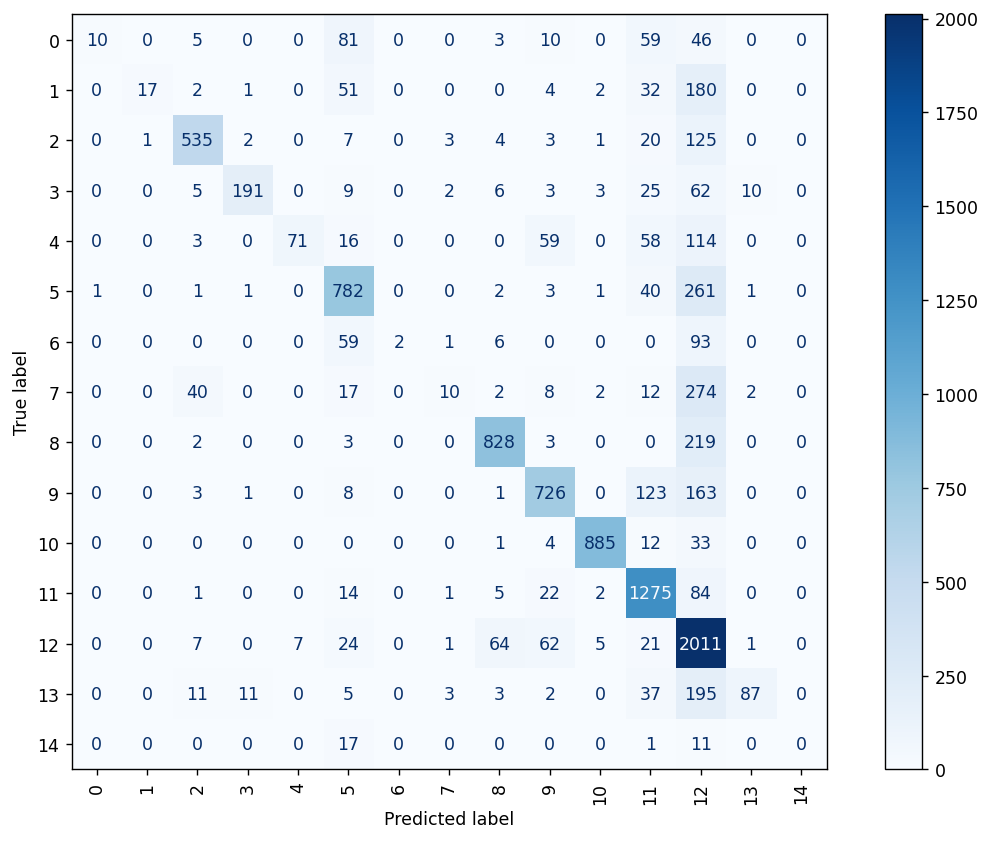

In [176]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 125
plot_confusion_matrix(nb, val_X_tfidf, val_y_sr_n, cmap=plt.cm.Blues, xticks_rotation='vertical')

### Logistic Regression

In [156]:
%%time
log_reg_model = LogisticRegression(random_state=0)
log_reg_model.fit(train_X_tfidf_svd,train_y_sr)

Wall time: 3.8 s


c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

#### Độ chính xác tập training

In [157]:
log_reg_model.score(train_X_tfidf_svd,train_y_sr)

0.814422013840547

#### Độ chính xác tập validation

In [159]:
prediction=log_reg_model.predict(val_X_tfidf_svd)
1 - (prediction != val_y_sr).mean()

0.8018534441578293

#### Confusion matrix

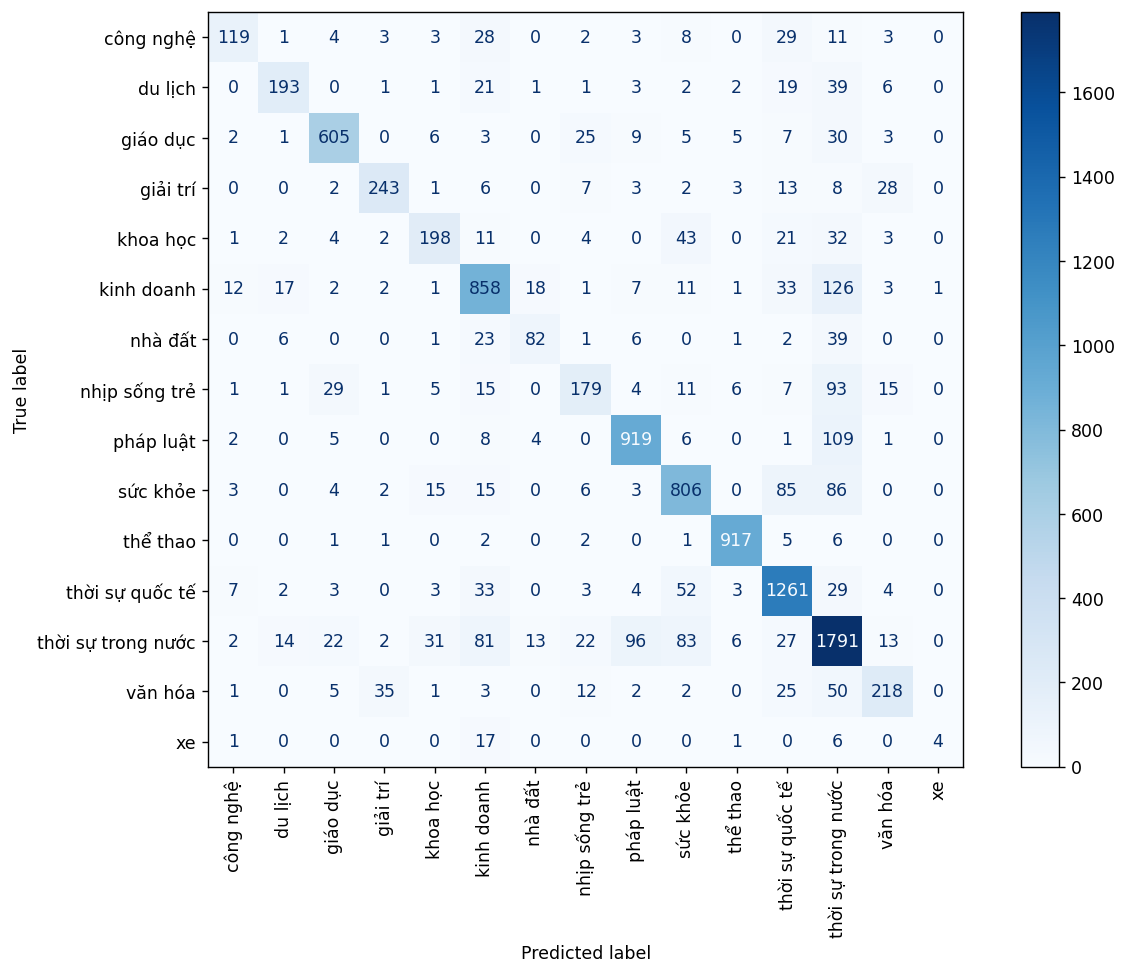

In [160]:
plot_confusion_matrix(log_reg_model,val_X_tfidf_svd,val_y_sr, cmap=plt.cm.Blues, xticks_rotation='vertical')

### Logistic Regression (sử dụng phương pháp bagging)

In [166]:
%%time
n_estimators = 10
log_reg_bag_model = BaggingClassifier(LogisticRegression(random_state=0), 
                                    n_estimators = n_estimators,
                                    max_samples=(1.0 / (4)), random_state=0)
log_reg_bag_model.fit(train_X_tfidf_svd,train_y_sr)

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Wall time: 36.4 s


BaggingClassifier(base_estimator=LogisticRegression(random_state=0),
                  max_samples=0.25, random_state=0)

#### Độ chính xác tập training

In [167]:
log_reg_bag_model.score(train_X_tfidf_svd,train_y_sr)

0.7833012571147783

#### Độ chính xác tập validation

In [169]:
prediction=log_reg_bag_model.predict(val_X_tfidf_svd)
1 - (prediction != val_y_sr).mean()

0.7774911627018248

#### Confusion matrix

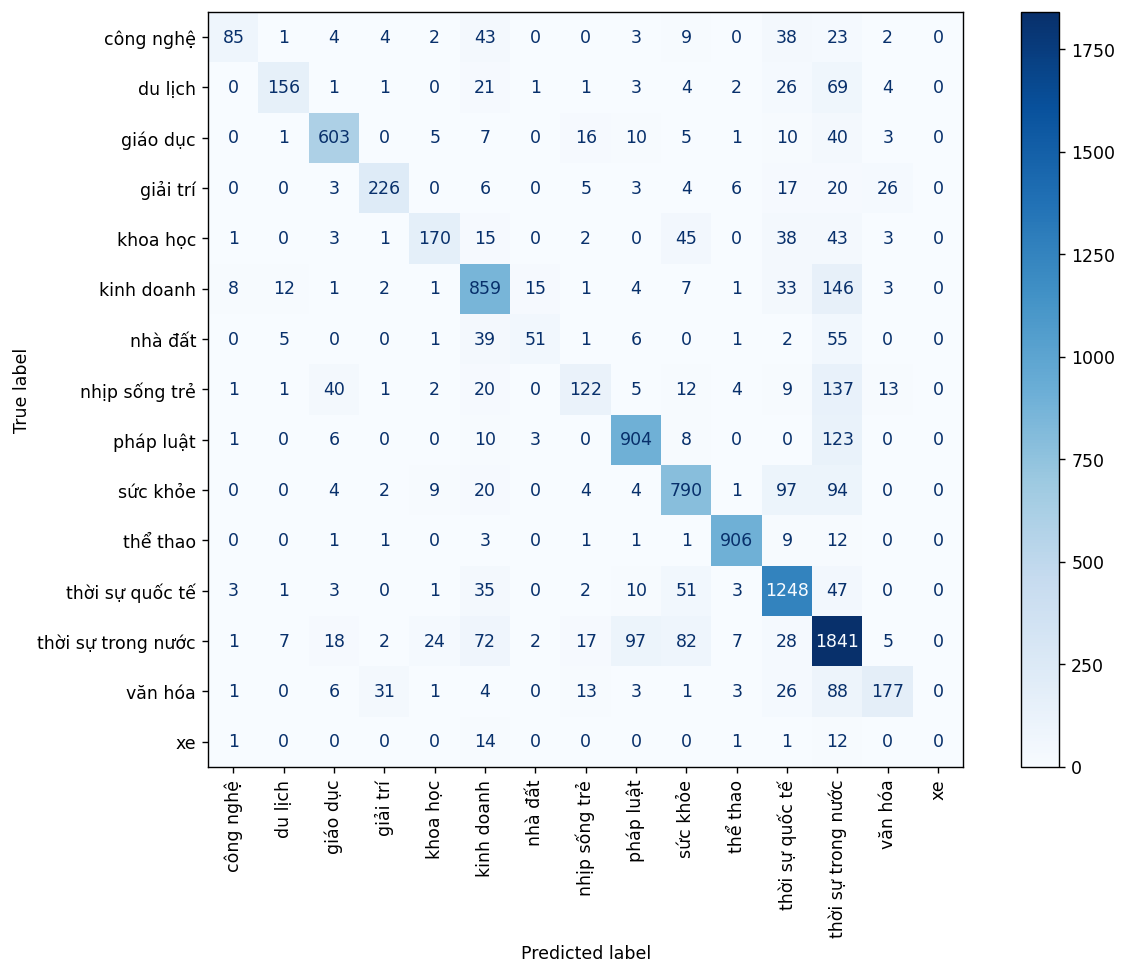

In [170]:
plot_confusion_matrix(log_reg_bag_model,val_X_tfidf_svd,val_y_sr, cmap=plt.cm.Blues, xticks_rotation='vertical')

### Neuron network

In [196]:
%%time
mlp_model = MLPClassifier(hidden_layer_sizes=(20), activation='tanh',
                                 solver='lbfgs', random_state=0, max_iter=2500)
mlp_model.fit(train_X_tfidf_svd,train_y_sr)

Wall time: 2min 27s


c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='tanh', hidden_layer_sizes=20, max_iter=2500,
              random_state=0, solver='lbfgs')

#### Độ chính xác tập training

In [197]:
mlp_model.score(train_X_tfidf_svd,train_y_sr)

0.9746939109782564

#### Độ chính xác tập validation

In [198]:
prediction=mlp_model.predict(val_X_tfidf_svd)
1 - (prediction != val_y_sr).mean()

0.7255182955956816

#### Confusion matrix

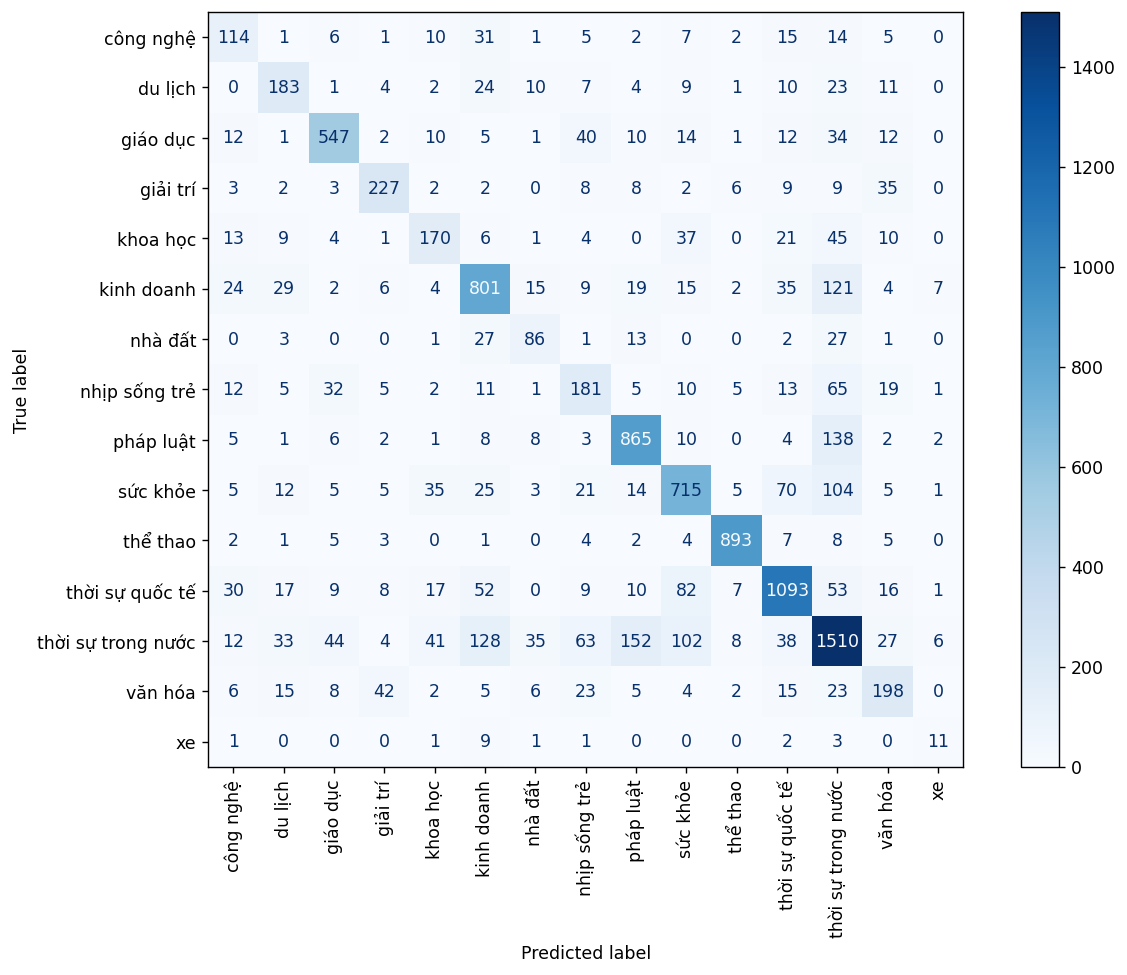

In [199]:
plot_confusion_matrix(mlp_model,val_X_tfidf_svd,val_y_sr, cmap=plt.cm.Blues, xticks_rotation='vertical')

### Neuron network (sử dụng phương pháp bagging)

In [200]:
%%time
n_estimators = 10
mlp_bag_model = BaggingClassifier(MLPClassifier(hidden_layer_sizes=(20), activation='tanh',
                                                    solver='lbfgs', random_state=0, max_iter=2500), 
                                    n_estimators = n_estimators,
                                    max_samples=(1.0 / (5)), random_state=0)
mlp_bag_model.fit(train_X_tfidf_svd,train_y_sr)

Wall time: 26.5 s


BaggingClassifier(base_estimator=MLPClassifier(activation='tanh',
                                               hidden_layer_sizes=20,
                                               max_iter=2500, random_state=0,
                                               solver='lbfgs'),
                  max_samples=0.2, random_state=0)

#### Độ chính xác tập training

In [201]:
mlp_bag_model.score(train_X_tfidf_svd,train_y_sr)

0.8619630645755703

#### Độ chính xác tập validation

In [202]:
prediction=mlp_bag_model.predict(val_X_tfidf_svd)
1 - (prediction != val_y_sr).mean()

0.8008980605713194

#### Confusion matrix

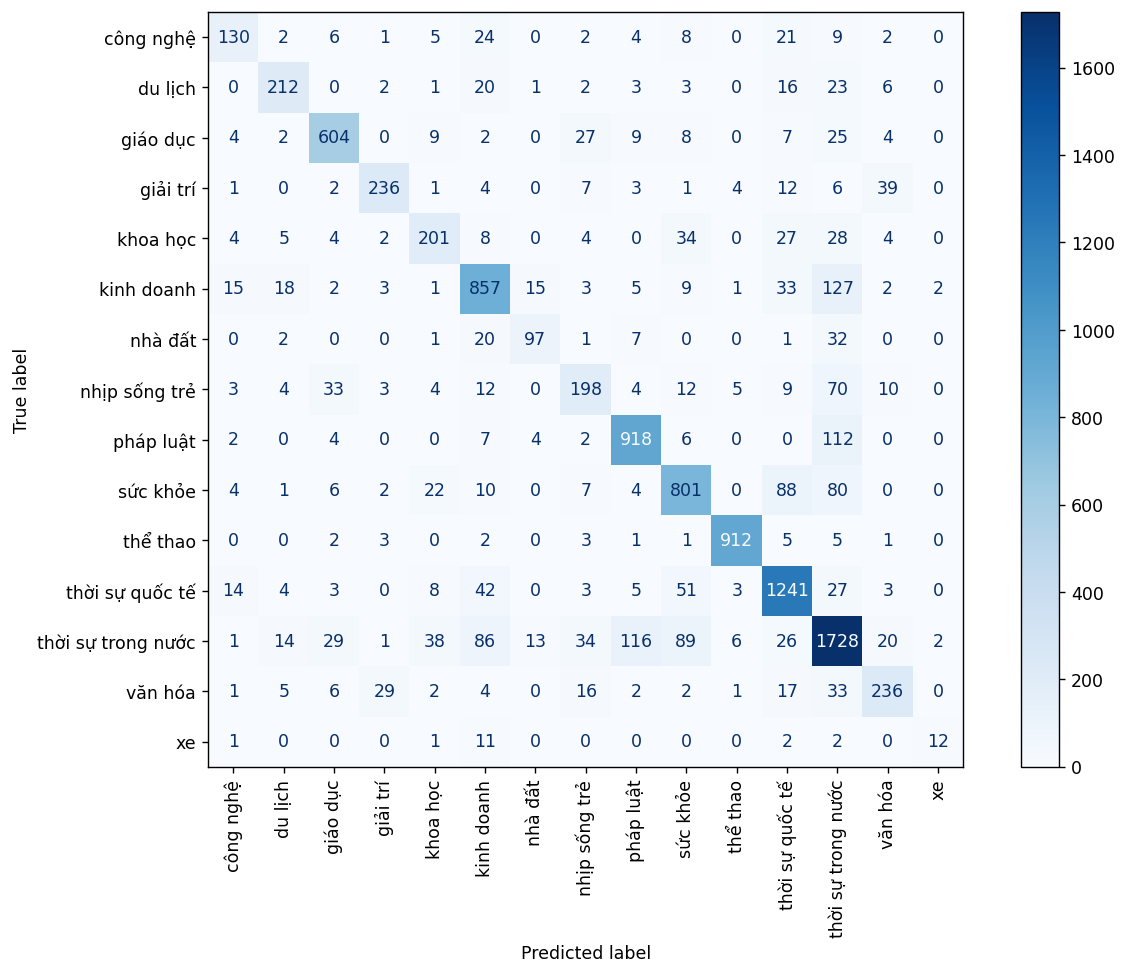

In [203]:
plot_confusion_matrix(mlp_bag_model,val_X_tfidf_svd,val_y_sr, cmap=plt.cm.Blues, xticks_rotation='vertical')

### Nhận xét và đánh giá

- Mô hình Naive Bayes chạy rất nhanh tuy nhiên kết quả kém nhất.
    > Điều này dễ hiểu vì tập dữ liệu khá nhỏ so với số lượng thuộc tính tạo bởi TF-IDF, đồng thời dữ liệu cũng bị lệch khá là nặng về vài lớp chiếm đa số (có thể thấy được trên confusion matrix kết quả predict có xu hướng tập trung vào class *"thời sự trong nước"* (12)).
- Mô hình logistic chạy chậm hơn rất nhiều nhưng cho kết quả khá hơn rất nhiều (khoảng 10%).
    > Chậm là điều hiển nhiên. Và dự đoán tốt hơn... cũng là điều hiển nhiên~.
- Khi sử dụng kỹ thuật bagging với mô hình logistic, thời gian chạy gấp lên xấp sỉ số lượng estimator. Tuy nhiên độ chính xác kém hơn mô hình không dùng bagging.
    > Bagging chia nhỏ dữ liệu ra cho 10 mô hình cùng học, khiến cho dữ liệu đã nhỏ sẵn nay còn nhỏ hơn. Việc bị fit vào một vài lớp chiếm đa số là không thể tránh khỏi.
- Mô hình neuron network chạy siêu chậm (gấp 20 lần logistic) mà lại bị overfit (độ chính xác tập train tận 97% mà độ chính xác tập validate có 72.5%).
    > Mô hình neuron network học "tốt quá" mà lại gặp dữ liệu khá thưa :v
- Áp dụng kỹ thuật bagging vào mô hình neuron network thì lại cho tốc độ chạy nhanh gấp 4 lần so với neuron network trước mà lại còn cho độ chính xác cao ngang mô hình logistic.
    > Phương pháp bagging đã biến bất lợi của mô hình neuron network là dễ bị overfit khi dữ liệu ít thành lợi thế. Nhờ vậy mà ở những lớp có số mẫu rất thấp như là *"xe"* đã được dự đoán tốt hơn, còn những lớp còn lại vẫn giữ được khả năng dự đoán chứ không bị giảm đi như mô hình neuron network gốc.

### Chọn mô hình sử dụng

Sau khi đánh giá xong, nhóm quyết định sẽ giữ lại mô hình Naive Bayes, logistic regression và neuron network có dùng phương pháp bagging để chạy thử nghiệm trên toàn bộ dữ liệu.

---
# Đánh giá và kết luận

## Đánh giá

### Chung về quy trình làm việc

- Thời gian làm khá gấp rút do phải ôn thi cuối kỳ, suy nghĩ đề tài muộn và một số sự cố không mong muốn (hư laptop).
- Không tìm được nguồn dữ liệu chuyên cho đề tài của nhóm.
- Thu thập được lượng lớn dữ liệu.
- Có khả năng tìm hiểu được các kiến thức cần thiết.
- Do dữ liệu khá lớn nên phải phân chi ra các quy trình khoa học dữ liệu riêng biệt và phân công mỗi thành viên nắm một quy trình riêng chứ không đồng thời cùng làm chung (tiền xử lý, khám phá, truyền thông lại cho tiền xử lý, xây dựng mô hình,...) (phần này nhóm không biết là điều xấu hay điều tốt nữa).
- Chưa có pipeline tổng quát.

### Đánh giá về mô hình của đồ án

- Độ chính xác không cao (khoảng 75-80%).
- Sử dụng phương pháp bagging để tăng tốc độ chạy mô hình neuron network mà lại giảm overfit.
- Không đủ khả năng chạy toàn bộ dữ liệu do thời gian xử lý khá lâu.

## Hướng phát triển

- Hoàn thiện pipeline.
- Thử thêm các mô hình tốt hơn và tìm cách để có thể chạy trên toàn dữ liệu với thời gian tốt.

---
# Tham khảo